# The e2e Model Lifecycle on SAS Viya Platform

In this notebook, 

1. Build and train the model.
2. Create an API of the model. (Here we have put it in a flask API).
3. Create the requirements file containing all the required libraries.
4. Create the docker file with necessary environment setup and start-up operations.
5. Build the docker image.

I train XGboost model for testing Docker Private ML environment

## Libraries

In [1]:
# Mongo Library

import pymongo

# ML libraries 

import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.base import TransformerMixin
import sklearn.metrics as metrics
import sklearn.model_selection as model_selection
import statsmodels.api as smodel
import xgboost as xgb

# Tool libraries

# import json
# import os
# import requests as req
# import random
# import pickle
# import zipfile
# import urllib
# import base64
# import time
# import sys

# import sasctl

## Utilities

In [2]:
# class DataFrameImputer(TransformerMixin):

#     def __init__(self):
#         """Impute missing values.

#         Columns of dtype object are imputed with the most frequent value 
#         in column.

#         Columns of other types are imputed with mean of column.

#         """
#     def fit(self, X, y=None):

#         self.fill = pd.Series([X[c].value_counts().index[0]
#             if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
#             index=X.columns)

#         return self

#     def transform(self, X, y=None):
        return X.fillna(self.fill)

## Data Engineering

## Load Data from Mongo

In [3]:
#Connect to mongodb container

conn = pymongo.MongoClient('mongo', 27017)

In [4]:
conn

MongoClient(host=['mongo:27017'], document_class=dict, tz_aware=False, connect=True)

In [5]:
db = conn.training
collection = db.churn_data

In [33]:
df = pd.DataFrame(list(collection.find()))
df.set_index('_id', inplace=True)
df.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
_id,,,,,,,,,,,,,
5e26d19517a1596a2416f8da,1,1100,25860,39025,HomeImp,Other,10.5,0,0,94.3667,1,9,
5e26d19517a1596a2416f8db,1,1300,70053,68400,HomeImp,Other,7,0,2,121.833,0,14,
5e26d19517a1596a2416f8dc,1,1500,13500,16700,HomeImp,Other,4,0,0,149.467,1,10,
5e26d19517a1596a2416f8dd,1,1500,,,,,,,,,,,
5e26d19517a1596a2416f8de,0,1700,97800,112000,HomeImp,Office,3,0,0,93.3333,0,14,


## Declare data types

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 65560 entries, 5e26d19517a1596a2416f8da to 5e26f2cfc9670dc5649fe7a5
Data columns (total 13 columns):
BAD        65560 non-null int64
LOAN       65560 non-null int64
MORTDUE    65560 non-null object
VALUE      65560 non-null object
REASON     65560 non-null object
JOB        65560 non-null object
YOJ        65560 non-null object
DEROG      65560 non-null object
DELINQ     65560 non-null object
CLAGE      65560 non-null object
NINQ       65560 non-null object
CLNO       65560 non-null object
DEBTINC    65560 non-null object
dtypes: int64(2), object(11)
memory usage: 7.0+ MB


In [35]:
cols = df[df.columns.difference(['BAD','LOAN','REASON','JOB'])].columns
df[cols] = df[cols].apply(pd.to_numeric, downcast='float', errors='coerce')
df['BAD']=df['BAD'].astype('category')

In [36]:
df.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
_id,,,,,,,,,,,,,
5e26d19517a1596a2416f8da,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366669,1.0,9.0,NaN
5e26d19517a1596a2416f8db,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833336,0.0,14.0,NaN
5e26d19517a1596a2416f8dc,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466660,1.0,10.0,NaN
5e26d19517a1596a2416f8dd,1,1500,NaN,NaN,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5e26d19517a1596a2416f8de,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333336,0.0,14.0,NaN


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 65560 entries, 5e26d19517a1596a2416f8da to 5e26f2cfc9670dc5649fe7a5
Data columns (total 13 columns):
BAD        65560 non-null category
LOAN       65560 non-null int64
MORTDUE    59862 non-null float32
VALUE      64328 non-null float32
REASON     65560 non-null object
JOB        65560 non-null object
YOJ        59895 non-null float32
DEROG      57772 non-null float32
DELINQ     59180 non-null float32
CLAGE      62172 non-null float32
NINQ       59950 non-null float32
CLNO       63118 non-null float32
DEBTINC    51623 non-null float32
dtypes: category(1), float32(9), int64(1), object(2)
memory usage: 4.3+ MB


## Declare variables 

In [39]:
target = list(df.select_dtypes('category').columns) #target var
class_inputs = list(df.select_dtypes('object').columns) #categorical (nominal and ordinal) variables
numerical_inputs = list(df.select_dtypes('float32').columns) #input interval variables
inputs = class_inputs + numerical_inputs

print(target)
print(class_inputs)
print(numerical_inputs)
print(inputs)

['BAD']
['REASON', 'JOB']
['MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']
['REASON', 'JOB', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']


In [47]:
df[inputs]

,REASON,JOB,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
_id,,,,,,,,,,,
5e26d19517a1596a2416f8da,HomeImp,Other,25860.0,39025.0,10.5,0.0,0.0,94.366669,1.0,9.0,NaN
5e26d19517a1596a2416f8db,HomeImp,Other,70053.0,68400.0,7.0,0.0,2.0,121.833336,0.0,14.0,NaN
5e26d19517a1596a2416f8dc,HomeImp,Other,13500.0,16700.0,4.0,0.0,0.0,149.466660,1.0,10.0,NaN
5e26d19517a1596a2416f8dd,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5e26d19517a1596a2416f8de,HomeImp,Office,97800.0,112000.0,3.0,0.0,0.0,93.333336,0.0,14.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
5e26f2cfc9670dc5649fe7a1,DebtCon,Other,54576.0,92937.0,16.0,0.0,0.0,208.692062,0.0,15.0,35.859970
5e26f2cfc9670dc5649fe7a2,HomeImp,,21694.0,103143.0,26.0,0.0,1.0,139.938995,0.0,14.0,31.333685
5e26f2cfc9670dc5649fe7a3,DebtCon,Other,54045.0,92924.0,15.0,0.0,0.0,212.279694,0.0,15.0,35.556591


## Impute missing

In [52]:
# def imputer(col):
#     if col.dtype == np.dtype('O'):
#         return col.value_counts().index[0]
#     else:
#         return col.mean()

# inputed_inputs = df[inputs].apply(imputer)apply(lambda x: x + 1)

# inputed_inputs
    

REASON     HomeImp
JOB        ProfExe
MORTDUE      47000
VALUE        80000
YOJ              1
DEROG            1
DELINQ           1
CLAGE        102.5
NINQ             1
CLNO            19
DEBTINC    30.7832
dtype: object

In [ ]:


pd.Series([X[c].value_counts().index[0] if X[c].dtype == np.dtype('O') else X[c].mean() for c in X], index=X.columns)

In [ ]:
inputdf_enc = DataFrameImputer().fit_transform(inputdf[inputs])
inputdf_enc_dummy = pd.concat([inputdf_enc, pd.get_dummies(inputdf_enc[class_input])], axis=1).drop(class_input, axis = 1)

## Machine Learning Model Development

## Machine Learning Engineering

In [32]:
# Preprocessing interval variables
numeric_transformer = Pipeline(steps=[
    ('imputation', SimpleImputer(strategy='median'))])

# Preprocessing categorical variables
categorical_transformer = Pipeline(steps=[
     ('imputation', SimpleImputer(strategy='most_frequent')),
     ('onehot-encoding', OneHotEncoder(handle_unknown='ignore'))])

# Create preprocessing step
preprocessor = ColumnTransformer(transformers=[
    ('numericals', numeric_transformer, numerical_inputs),
    ('categoricals', categorical_transformer, class_inputs)])

In [43]:
print(inputdf_enc_dummy)

                               CLAGE       CLNO    DEBTINC    DELINQ    DEROG  \
_id                                                                             
5e243bf1e607ed91944025fa   94.366669   9.000000  33.779919  0.000000  0.00000   
5e243bf1e607ed91944025fb   93.333336  14.000000  33.779919  0.000000  0.00000   
5e243bf1e607ed91944025fc  179.766281  21.296097  33.779919  0.449442  0.25457   
5e243bf1e607ed91944025fd  101.466003   8.000000  37.113613  0.000000  0.00000   
5e243bf1e607ed91944025fe   77.099998  17.000000  33.779919  2.000000  3.00000   
...                              ...        ...        ...       ...      ...   
5e2610a4945d0653a1986903  212.279694  15.000000  35.556591  0.000000  0.00000   
5e2610a4945d0653a1986904  205.650162  15.000000  34.818260  1.000000  0.00000   
5e2610a4945d0653a1986905  193.702057  15.000000  36.262691  0.000000  0.00000   
5e2610a4945d0653a1986906  208.692062  15.000000  35.859970  0.000000  0.00000   
5e2610a4945d0653a1986907  21

## Model Training 

In [44]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(inputdf_enc_dummy, inputdf[dec_target], 
                                                                    test_size=0.33, random_state=27513)

In [45]:
%%time

model = xgb.XGBClassifier(max_depth=4,
                        subsample=0.9,
                        objective='binary:logistic',
                        n_estimators=200,
                        learning_rate = 0.1)
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train.values.ravel(), early_stopping_rounds=10,
          eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True)

[0]	validation_0-error:0.12951	validation_0-logloss:0.63257	validation_1-error:0.13007	validation_1-logloss:0.63271
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 10 rounds.
[1]	validation_0-error:0.12857	validation_0-logloss:0.58331	validation_1-error:0.12995	validation_1-logloss:0.58394
[2]	validation_0-error:0.12882	validation_0-logloss:0.54186	validation_1-error:0.12995	validation_1-logloss:0.54273
[3]	validation_0-error:0.12891	validation_0-logloss:0.50948	validation_1-error:0.13232	validation_1-logloss:0.51068
[4]	validation_0-error:0.11910	validation_0-logloss:0.48282	validation_1-error:0.12274	validation_1-logloss:0.48442
[5]	validation_0-error:0.11914	validation_0-logloss:0.45933	validation_1-error:0.12317	validation_1-logloss:0.46117
[6]	validation_0-error:0.11632	validation_0-logloss:0.43921	validation_1-error:0.12126	validation_1-logloss:0.44201
[7]	validation_0-error:

[69]	validation_0-error:0.07459	validation_0-logloss:0.19658	validation_1-error:0.07686	validation_1-logloss:0.20273
[70]	validation_0-error:0.07371	validation_0-logloss:0.19551	validation_1-error:0.07609	validation_1-logloss:0.20161
[71]	validation_0-error:0.07358	validation_0-logloss:0.19398	validation_1-error:0.07584	validation_1-logloss:0.19999
[72]	validation_0-error:0.07342	validation_0-logloss:0.19372	validation_1-error:0.07567	validation_1-logloss:0.19971
[73]	validation_0-error:0.07321	validation_0-logloss:0.19266	validation_1-error:0.07508	validation_1-logloss:0.19860
[74]	validation_0-error:0.07302	validation_0-logloss:0.19207	validation_1-error:0.07495	validation_1-logloss:0.19802
[75]	validation_0-error:0.07200	validation_0-logloss:0.19078	validation_1-error:0.07398	validation_1-logloss:0.19665
[76]	validation_0-error:0.07104	validation_0-logloss:0.18920	validation_1-error:0.07287	validation_1-logloss:0.19517
[77]	validation_0-error:0.07075	validation_0-logloss:0.18794	val

[139]	validation_0-error:0.05065	validation_0-logloss:0.14411	validation_1-error:0.05377	validation_1-logloss:0.14941
[140]	validation_0-error:0.05069	validation_0-logloss:0.14330	validation_1-error:0.05368	validation_1-logloss:0.14858
[141]	validation_0-error:0.05069	validation_0-logloss:0.14317	validation_1-error:0.05368	validation_1-logloss:0.14845
[142]	validation_0-error:0.05050	validation_0-logloss:0.14296	validation_1-error:0.05355	validation_1-logloss:0.14826
[143]	validation_0-error:0.05050	validation_0-logloss:0.14278	validation_1-error:0.05355	validation_1-logloss:0.14810
[144]	validation_0-error:0.04977	validation_0-logloss:0.14200	validation_1-error:0.05250	validation_1-logloss:0.14725
[145]	validation_0-error:0.04977	validation_0-logloss:0.14184	validation_1-error:0.05250	validation_1-logloss:0.14708
[146]	validation_0-error:0.04967	validation_0-logloss:0.14146	validation_1-error:0.05220	validation_1-logloss:0.14666
[147]	validation_0-error:0.04931	validation_0-logloss:0.

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.9,
              tree_method='auto', validate_parameters=False, verbosity=1)

## Model Assessment

In [46]:
dt_misclassification = 1 - metrics.accuracy_score(y_test, model.predict(X_test))
print('Misclassification Rates\n', 'XGBoost :', dt_misclassification)

Misclassification Rates
 XGBoost : 0.042199813575120704


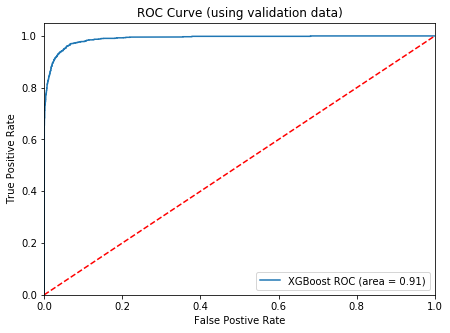

In [47]:
models = [{'label': 'XGBoost','model': model}]

plt.figure(figsize = (7, 5))
for m in models:
    model = m['model']
    fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict_proba(X_test)[:,1])
    auc = metrics.roc_auc_score(y_test,model.predict(X_test))
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Postive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (using validation data)')
plt.legend(loc="lower right")
plt.show()

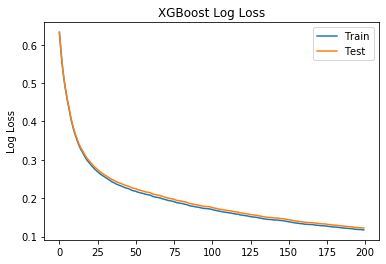

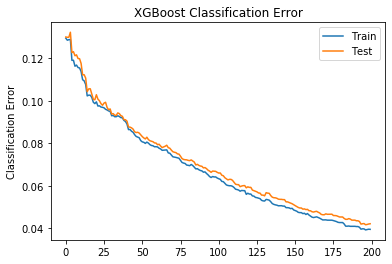

In [48]:
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()


# Model Deployment

For Model Deployment purpose, we need some files:

    0. requirement.txt    
    1. score.py
    2. model.pickle
    3. dmcas_fitstat.json
    4. inputVar.json
    5. outputVar.json
    6. fileMetadata.json
    7. ModelProperties.json


## 1. requirement.txt

In [50]:
! pip freeze > requirement.txt

## 2. Score.py 

## 4. inputVar.py

In [9]:
from utils import modelmanager_service

In [10]:
modelmanager_utils.inputjson()

TypeError: inputjson() missing 3 required positional arguments: 'traindf', 'target', and 'outdir'